# Product Categories Classification with Keras - Training and Tuning

## Author: Luis Eduardo Ferro Diez, <a href="mailto:luisedof10@gmail.com">luisedof10@gmail.com</a>

This notebook contains the process of using the pre-trained document embeddings (doc2vec) using the product reviews and metadata from amazon. Each review is for a signle product, each product might belong to one or more categories.

Each record in the dataset contains the categories, title (of the product), description (of the product), summary (of the review) and review text. Hence, with the pre-trained document embeddings model we proceed to infer the document vectors of the input dataset and submit them to classification with a convolutional neural network in keras.

We also proceed to perform hyperparameter tuning to see what is the best combination of parameters for the neural network.

In [1]:
import os

os.environ['MODIN_CPUS'] = "8"
os.environ['MODIN_OUT_OF_CORE'] = "true"

In [3]:
import modin.pandas as pd

reviews_path = "<product-documents-path>"
reviews = pd.read_parquet(reviews_path, engine="pyarrow")
reviews.head()

,categories,document
0,"Home & Kitchen;Technology, Electronics & Acces...","Jim from Ocala, Fl.\ngreat replacement product..."
1,Sports & Outdoors,Good buy\nI have been pleased with this ball s...
2,Toys & Games,Great Addition to a Magic Kit\nI purchased thi...
3,"Technology, Electronics & Accessories",Roku 3\nReplaced my Apple TV with this because...
4,Toys & Games,What can I say? Pagan Fluxx!\nWe just love Fl...


In [4]:
reviews.shape

(1553620, 2)

In [5]:
from gensim.models import Doc2Vec

d2v_model = Doc2Vec.load("../../../models/embeddings/d2v_model.model")

## Classification of the categories

We are treating the documents as multi category entities, i.e., one document can belong to more than one category. Hence, we train a multi label binarizer.

In [7]:
categories = reviews.categories.apply(lambda cat: cat.split(";")).values.tolist()

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

categories_encoder = MultiLabelBinarizer()
categories_encoder.fit(categories)

MultiLabelBinarizer(classes=None, sparse_output=False)

### Define a Baseline
Since there is no prior existence of a model for classifying this particular dataset, we define the baseline to be the predominant class in the dataset which is 'Books'. From this we can calculate the baseline to beat with the classifier.

In [16]:
from collections import Counter

flat_categories = [item for sublist in categories for item in sublist]
count = Counter(flat_categories)

In [17]:
sorted(count.items(), key=lambda kv: kv[1], reverse=True)

[('Books', 457672),
 ('Technology, Electronics & Accessories', 269065),
 ('Home & Kitchen', 249313),
 ('Clothing, Shoes & Jewelry', 162550),
 ('Health & Personal Care', 125661),
 ('Toys & Games', 117803),
 ('Sports & Outdoors', 104651),
 ('Music', 82883),
 ('Movies & TV', 80190),
 ('Office & School Supplies', 28248)]

In [18]:
count['Books'] / len(categories)

0.29458426127367054

Our baseline to beat is $0.294$ or $29\%$, with Books being the predominant class.

#### Infer document vectors
This cell will take the input data set and infer the document vectors for each of them and create the corresponding features (`X`) and labels (`y`) for the neural network training. This section will also perform the train/test split for validation. Depending on the size of the dataset, this cell might take some time to execute. For a ~1.5 million of documents, this took ~10 min to complete.

In [19]:
%%time
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

y = categories_encoder.transform(categories)
X = reviews.apply(lambda row: d2v_model.infer_vector([word.lower() for word in tokenizer.tokenize(row['document'])]), axis=1)._to_pandas()
X = X.apply(lambda x: x[0], axis=1, result_type='expand')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

CPU times: user 2min 45s, sys: 8.87 s, total: 2min 54s
Wall time: 10min 18s


In [20]:
X.shape

(1553620, 300)

Save the features and labels to avoid recomputing them in the future.

In [21]:
%%time
np.savez_compressed("../../../models/document_vectors/product_embeddings.npz", x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test)

CPU times: user 1min 7s, sys: 862 ms, total: 1min 8s
Wall time: 1min 7s


In [9]:
import numpy as np

embeddings = np.load("../../../models/document_vectors/product_embeddings.npz")
X_train = embeddings['x_train']
X_test = embeddings['x_test']
y_train = embeddings['y_train']
y_test = embeddings['y_test']

### Initialize tensorflow
This cell will simply put two properties into tensorflow configuration, `allow_growth` and `per_process_gpu_memory_fraction` so it can make effective use of the GPU installed. Finally, it defines a simple method to show the current active devices so we can be sure it will use the GPUs installed.

In [10]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.python.client import device_lib
                                                                     
config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = InteractiveSession(config=config)


def show_framework_devices():
    """Just prints the devices the frameworks are using
    at the moment. It will help us to tell if they are indeed
    using GPU's or not"""
    print("Tensorflow registered devices:", device_lib.list_local_devices())

In [11]:
show_framework_devices()

Tensorflow registered devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11714057579676053181
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11849409644859499103
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5022036787
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14789188132389232441
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9138286286028563538
physical_device_desc: "device: XLA_GPU device"
]


In [12]:
X_train.shape

(1087534, 300)

We know before hand that the embeddings have 300 dimensions, and that we have 10 classes. So we just put them here to emphasize it.

In [13]:
vec_size = 300
classes = y_train[0].shape[0]

#### Train a first guess neural network
The network below is a manual attempt to derive an architecture to infer the document categories. This is just to validate a simple approach to test the network is suitable to classify the documents.

In [14]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam

# Define the inputs
comment_input = Input(shape=(vec_size,1), dtype='float32', name='comment_text')

# Convolutional layers
conv = Conv1D(256, 5, activation='tanh', input_shape=(vec_size,), kernel_regularizer=regularizers.l2())(comment_input)
conv = MaxPool1D(2, strides=1, padding='valid')(conv)
conv = Conv1D(128, 4, activation='tanh')(conv)
conv = SpatialDropout1D(0.2)(conv)
conv = MaxPool1D(2, strides=1, padding='valid')(conv)
conv = Conv1D(64, 4, activation='tanh')(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv_output = Flatten()(conv)


# Dense layers
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2())(conv_output)
x = Dense(128, activation='relu')(conv_output)
x = Dropout(0.5)(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(classes, activation='softmax', name='prediction')(x)

ann_model = Model(inputs=comment_input, outputs=main_output)
optimizer = Adam(learning_rate=0.00001)
ann_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 300, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 256)          1536      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 295, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 292, 128)          131200    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 292, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 291, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 288, 64)           3283

We have a network with a considerable number of parameters. Now let's see how it behaves predicting the document categories.

In [15]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7, restore_best_weights=True)
sample_size = 10000
X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
history = ann_model.fit(X_train_rs, 
                        y_train, 
                        epochs = 100, 
                        batch_size = 2000, 
                        validation_split= 0.2, 
                        callbacks=[early_stopping])

Train on 870027 samples, validate on 217507 samples
Epoch 1/100
870027/870027 [==============================] - 119s 137us/step - loss: 1.8248 - accuracy: 0.4837 - val_loss: 0.9744 - val_accuracy: 0.7651
Epoch 2/100
870027/870027 [==============================] - 114s 131us/step - loss: 1.0185 - accuracy: 0.7407 - val_loss: 0.8268 - val_accuracy: 0.7980
Epoch 3/100
870027/870027 [==============================] - 114s 131us/step - loss: 1.2532 - accuracy: 0.7433 - val_loss: 1.0920 - val_accuracy: 0.8002
Epoch 4/100
870027/870027 [==============================] - 114s 131us/step - loss: 2.0149 - accuracy: 0.7356 - val_loss: 1.7937 - val_accuracy: 0.7969
Epoch 5/100
870027/870027 [==============================] - 115s 132us/step - loss: 3.4253 - accuracy: 0.7246 - val_loss: 2.8198 - val_accuracy: 0.7944
Epoch 6/100
870027/870027 [==============================] - 115s 132us/step - loss: 5.1215 - accuracy: 0.7169 - val_loss: 3.8891 - val_accuracy: 0.7921
Epoch 7/100
870027/870027 [===

In [19]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()

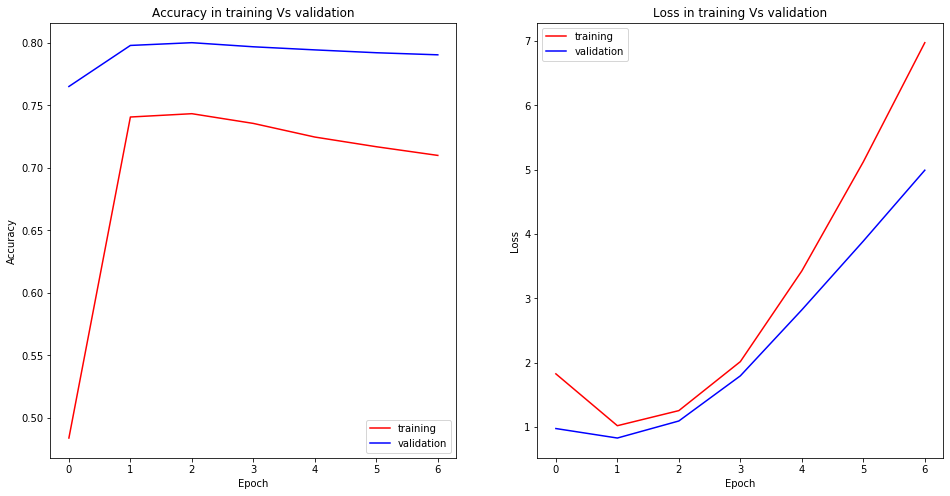

In [20]:
plot_history(history, 
             acc='accuracy', 
             val_acc='val_accuracy', 
             loss='loss', 
             val_loss='val_loss')

The network above is able to reach an accuracy of $0.79$ or $79\%$ which is good compared to our baseline.

## Hyperparameter Tuning
Now, let's explore different network configurations to explore other architectures and see if we can have better performance.

For this, we used the `kerastuner` package to try different configurations within a random search setting. We decided to manipulate the following hyper parameters:
* Number of convolutional layers
* Number of dense layers
* Regularization for convolutional layers
* Regularization for dense layers
* Units for convolutional layers (range from 32 to 512)
* Filters for convolutional layers
* Max pooling size for convolutional layers
* Activation functions (tanh and relu) for convolutional layers
* Activation functions (tanh and relu) for dense layers
* Spatial dropout fraction for convolutional layers
* Units for dense layers (range from 32 to 512)
* Dropout fraction for dense layers
* Learning rate (with Adam optimizer)

We tried with: 
* A subset of 100000 documents from the input dataset
* 20 epochs per trial
* 3 trials per configuration
* validation split of 0.2
* batch size of 2000

**Note:** In every iteration we halve the units for both the convolutional and dense layers to simulate a shrinking layer size.

In [21]:
sample_size = 100000
batch_size = 2000
epochs = 20
trials = 3
validation_split = 0.2

In [22]:
from kerastuner import HyperModel, RandomSearch, HyperParameters
import tensorflow as tf

class ProductClassifierHyperModel(HyperModel):
    def __init__(self, num_classes, vec_size, print_summary=False, halve_on_iteration=True):
        self.num_classes = num_classes
        self.vec_size = vec_size
        self.print_summary = print_summary
        self.halve_on_iteration = halve_on_iteration
    
    def get_regularizer(self, name: str):
        if name == 'l1':
            return tf.keras.regularizers.l1()
        elif name == 'l2':
            return tf.keras.regularizers.l2()
        elif name == 'l1l2':
            return tf.keras.regularizers.l1_l2()
        else:
            return None
    
    def build(self, hp: HyperParameters):
        print(f"Processing hyper parameter values: {hp.values}")
        comment_input = tf.keras.Input(shape=(self.vec_size, 1), dtype='float32', name='comment_text')
        x = comment_input
        
        filters = hp.Int('conv_filters', min_value=32, max_value=512, step=32, default=128)
        kernel_size = hp.Int('conv_kernel_size', min_value=2, max_value=6, step=1, default=2)
        for i in range(hp.Int('conv_layers', min_value=3, max_value=6, step=1)):
            x = tf.keras.layers.Conv1D(filters=filters, 
                                       kernel_size=kernel_size, 
                                       activation=hp.Choice('conv_activation',
                                                           ['relu', 'tanh']), 
                                       kernel_regularizer=self.get_regularizer(hp.Choice('conv_regularizer',
                                                                                   ['none', 'l1', 'l2', 'l1l2']))
                                      )(x)
        
            x = tf.keras.layers.SpatialDropout1D(rate=hp.Float('spatial_dropout',
                                                          min_value=0.1,
                                                          max_value=0.5,
                                                          step=0.1,
                                                          default=0.1))(x)
            x = tf.keras.layers.MaxPool1D(pool_size=hp.Int('maxpool_size',
                                                      min_value=2,
                                                      max_value=3,
                                                      default=2), 
                                          strides=2, 
                                          padding='valid')(x)
            if self.halve_on_iteration:
                filters = max(32, filters // 2)
                kernel_size = max(2, kernel_size // 2)


        x = tf.keras.layers.Flatten()(x)
        
        dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32, default=128)
        for i in range(hp.Int('dense_layers', min_value=2, max_value=5, default=2)):
            x = tf.keras.layers.Dense(units=dense_units, 
                                      activation=hp.Choice('dense_activation',
                                                          ['relu', 'tanh']), 
                                      kernel_regularizer=self.get_regularizer(hp.Choice('dense_regularizer',
                                                                                  ['none', 'l1', 'l2', 'l1l2']))
                                     )(x)

            x = tf.keras.layers.Dropout(rate=hp.Float('dropout',
                                                     min_value=0.1,
                                                     max_value=0.5,
                                                     step=0.1,
                                                     default=0.1))(x)
            if self.halve_on_iteration:
                dense_units = max(32, dense_units // 2)

        main_output = tf.keras.layers.Dense(self.num_classes, activation='softmax', name='prediction')(x)

        ann_model = tf.keras.Model(inputs=comment_input, outputs=main_output)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 
                                                                    min_value=1e-7,
                                                                    max_value=1e-2,
                                                                    sampling='log'))
        
        ann_model.compile(
            optimizer=optimizer, 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        if self.print_summary:
            print(ann_model.summary())
        return ann_model
    
hypermodel = ProductClassifierHyperModel(num_classes=10, vec_size=300, print_summary=False, halve_on_iteration=True)
hp = HyperParameters()
hp.Int('conv_filters', min_value=32, max_value=512, step=32, default=128)
hp.Int('conv_kernel_size', min_value=2, max_value=6, step=1, default=2)
hp.Int('maxpool_size', min_value=2, max_value=3, step=1, default=3)
hp.Choice('conv_activation', ['relu', 'tanh'])
hp.Choice('dense_activation', ['relu', 'tanh'])
hp.Float('spatial_dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.1)
hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.1)
hp.Int('dense_layers', min_value=2, max_value=5, step=1, default=2)
hp.Int('conv_layers', min_value=3, max_value=6, step=1, default=3)
hp.Choice('conv_regularizer', ['none', 'l1', 'l2', 'l1l2'])
hp.Choice('dense_regularizer', ['none', 'l1', 'l2', 'l1l2'])
hp.Int('dense_units', min_value=64, max_value=512, step=32, default=128)
hp.Float('learning_rate', min_value=1e-7, max_value=1e-2, sampling='log')

tuner = RandomSearch(
    hypermodel,
    hyperparameters=hp,
    objective='val_loss',
    max_trials=4,
    executions_per_trial=3,
    directory='../../../models/kerastuner',
    project_name='wtsp'
)

X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_train = X_train_rs[:sample_size]
y_train1 = y_train[:sample_size]

tuner.search(x_train, y_train1,
            epochs=epochs,
            batch_size = batch_size, 
            validation_split= validation_split,
            verbose=2)

Processing hyper parameter values: {'conv_filters': 128, 'conv_kernel_size': 2, 'maxpool_size': 3, 'conv_activation': 'relu', 'dense_activation': 'relu', 'spatial_dropout': 0.1, 'dropout': 0.1, 'dense_layers': 2, 'conv_layers': 3, 'conv_regularizer': 'none', 'dense_regularizer': 'none', 'dense_units': 128, 'learning_rate': 1e-07}
Processing hyper parameter values: {'conv_filters': 384, 'conv_kernel_size': 4, 'maxpool_size': 3, 'conv_activation': 'tanh', 'dense_activation': 'tanh', 'spatial_dropout': 0.1, 'dropout': 0.30000000000000004, 'dense_layers': 3, 'conv_layers': 3, 'conv_regularizer': 'none', 'dense_regularizer': 'l1l2', 'dense_units': 384, 'learning_rate': 1.1682481267584367e-06}
Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 - 10s - loss: 322.2267 - accuracy: 0.0832 - val_loss: 321.8810 - val_accuracy: 0.0680
Epoch 2/20
80000/80000 - 9s - loss: 321.5485 - accuracy: 0.0911 - val_loss: 321.2028 - val_accuracy: 0.0675
Epoch 3/20
80000/80000 - 9s - loss: 

Processing hyper parameter values: {'conv_filters': 384, 'conv_kernel_size': 5, 'maxpool_size': 2, 'conv_activation': 'relu', 'dense_activation': 'tanh', 'spatial_dropout': 0.1, 'dropout': 0.2, 'dense_layers': 2, 'conv_layers': 5, 'conv_regularizer': 'none', 'dense_regularizer': 'none', 'dense_units': 416, 'learning_rate': 1.9698134750928272e-06}
Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 - 10s - loss: 2.4832 - accuracy: 0.1329 - val_loss: 2.4856 - val_accuracy: 0.2883
Epoch 2/20
80000/80000 - 9s - loss: 2.4806 - accuracy: 0.1943 - val_loss: 2.4829 - val_accuracy: 0.2914
Epoch 3/20
80000/80000 - 9s - loss: 2.4773 - accuracy: 0.2426 - val_loss: 2.4795 - val_accuracy: 0.2914
Epoch 4/20
80000/80000 - 9s - loss: 2.4733 - accuracy: 0.2693 - val_loss: 2.4752 - val_accuracy: 0.2914
Epoch 5/20
80000/80000 - 9s - loss: 2.4683 - accuracy: 0.2830 - val_loss: 2.4696 - val_accuracy: 0.2914
Epoch 6/20
80000/80000 - 9s - loss: 2.4619 - accuracy: 0.2899 - val_loss: 2.4627

Processing hyper parameter values: {'conv_filters': 288, 'conv_kernel_size': 2, 'maxpool_size': 3, 'conv_activation': 'tanh', 'dense_activation': 'tanh', 'spatial_dropout': 0.30000000000000004, 'dropout': 0.30000000000000004, 'dense_layers': 3, 'conv_layers': 5, 'conv_regularizer': 'l1', 'dense_regularizer': 'none', 'dense_units': 352, 'learning_rate': 2.9062220047676503e-06}
Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 - 9s - loss: 56.2994 - accuracy: 0.1113 - val_loss: 56.2190 - val_accuracy: 0.1054
Epoch 2/20
80000/80000 - 7s - loss: 56.1589 - accuracy: 0.1274 - val_loss: 56.0800 - val_accuracy: 0.1695
Epoch 3/20
80000/80000 - 7s - loss: 56.0187 - accuracy: 0.1405 - val_loss: 55.9409 - val_accuracy: 0.2773
Epoch 4/20
80000/80000 - 7s - loss: 55.8792 - accuracy: 0.1586 - val_loss: 55.8016 - val_accuracy: 0.2912
Epoch 5/20
80000/80000 - 7s - loss: 55.7398 - accuracy: 0.1788 - val_loss: 55.6620 - val_accuracy: 0.2914
Epoch 6/20
80000/80000 - 7s - loss: 55.59

Processing hyper parameter values: {'conv_filters': 192, 'conv_kernel_size': 4, 'maxpool_size': 2, 'conv_activation': 'relu', 'dense_activation': 'tanh', 'spatial_dropout': 0.1, 'dropout': 0.4, 'dense_layers': 5, 'conv_layers': 3, 'conv_regularizer': 'none', 'dense_regularizer': 'none', 'dense_units': 192, 'learning_rate': 3.2915512297055932e-06}
Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 - 5s - loss: 2.4893 - accuracy: 0.1054 - val_loss: 2.4793 - val_accuracy: 0.1233
Epoch 2/20
80000/80000 - 4s - loss: 2.4766 - accuracy: 0.1269 - val_loss: 2.4672 - val_accuracy: 0.2470
Epoch 3/20
80000/80000 - 4s - loss: 2.4646 - accuracy: 0.1458 - val_loss: 2.4549 - val_accuracy: 0.2908
Epoch 4/20
80000/80000 - 4s - loss: 2.4534 - accuracy: 0.1632 - val_loss: 2.4420 - val_accuracy: 0.3290
Epoch 5/20
80000/80000 - 4s - loss: 2.4425 - accuracy: 0.1749 - val_loss: 2.4282 - val_accuracy: 0.3273
Epoch 6/20
80000/80000 - 4s - loss: 2.4317 - accuracy: 0.1887 - val_loss: 2.4141 

INFO:tensorflow:Oracle triggered exit


Let's observe the best model from these trials

In [23]:
tuner.get_best_hyperparameters()[0].values

{'conv_filters': 384,
 'conv_kernel_size': 5,
 'maxpool_size': 2,
 'conv_activation': 'relu',
 'dense_activation': 'tanh',
 'spatial_dropout': 0.1,
 'dropout': 0.2,
 'dense_layers': 2,
 'conv_layers': 5,
 'conv_regularizer': 'none',
 'dense_regularizer': 'none',
 'dense_units': 416,
 'learning_rate': 1.9698134750928272e-06}

In [24]:
tuner.get_best_models()[0].summary()

Processing hyper parameter values: {'conv_filters': 384, 'conv_kernel_size': 5, 'maxpool_size': 2, 'conv_activation': 'relu', 'dense_activation': 'tanh', 'spatial_dropout': 0.1, 'dropout': 0.2, 'dense_layers': 2, 'conv_layers': 5, 'conv_regularizer': 'none', 'dense_regularizer': 'none', 'dense_units': 416, 'learning_rate': 1.9698134750928272e-06}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    [(None, 300, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 384)          2304      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 296, 384)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 384)          0         
__________________________________________

The best network has significantly less parameters to train than our manually crafted one. Let's re create it separately and try again with the full data set and find observe the results.

In [28]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam

#Define the inputs
comment_input = Input(shape=(vec_size,1), dtype='float32', name='comment_text')

conv = Conv1D(384, 5, activation='relu')(comment_input)
conv = SpatialDropout1D(0.1)(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)

conv = Conv1D(192, 2, activation='relu')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)

conv = Conv1D(96, 2, activation='relu')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)

conv = Conv1D(48, 2, activation='relu')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)

conv = Conv1D(32, 2, activation='relu')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv = MaxPool1D(2, strides=2, padding='valid')(conv)


conv_output = Flatten()(conv)


#Apply a dense layers
x = Dense(416, activation='tanh')(conv_output)
x = Dropout(0.2)(x)
x = Dense(208, activation='tanh')(x)
x = Dropout(0.2)(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(classes, activation='softmax', name='prediction')(x)

ann_model = Model(inputs=comment_input, outputs=main_output)
optimizer = Adam(learning_rate=0.000019)
ann_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 300, 1)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 296, 384)          2304      
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 296, 384)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 148, 384)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 147, 192)          147648    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 147, 192)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 73, 192)           0   

In [29]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-7, restore_best_weights=True)
X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
history = ann_model.fit(X_train_rs, 
                        y_train, 
                        epochs = 100, 
                        batch_size = 2000, 
                        validation_split= 0.2, 
                        callbacks=[early_stopping],
                        verbose=2)

Train on 870027 samples, validate on 217507 samples
Epoch 1/100
 - 102s - loss: 2.2556 - accuracy: 0.3017 - val_loss: 1.9735 - val_accuracy: 0.3959
Epoch 2/100
 - 105s - loss: 1.8145 - accuracy: 0.4412 - val_loss: 1.4996 - val_accuracy: 0.5518
Epoch 3/100
 - 107s - loss: 1.4562 - accuracy: 0.5598 - val_loss: 1.1718 - val_accuracy: 0.6600
Epoch 4/100
 - 102s - loss: 1.2192 - accuracy: 0.6439 - val_loss: 1.0367 - val_accuracy: 0.7064
Epoch 5/100
 - 101s - loss: 1.1194 - accuracy: 0.6789 - val_loss: 0.9705 - val_accuracy: 0.7312
Epoch 6/100
 - 101s - loss: 1.0634 - accuracy: 0.6993 - val_loss: 0.9308 - val_accuracy: 0.7456
Epoch 7/100
 - 98s - loss: 1.0262 - accuracy: 0.7143 - val_loss: 0.9040 - val_accuracy: 0.7551
Epoch 8/100
 - 98s - loss: 0.9995 - accuracy: 0.7239 - val_loss: 0.8830 - val_accuracy: 0.7639
Epoch 9/100
 - 98s - loss: 0.9804 - accuracy: 0.7314 - val_loss: 0.8683 - val_accuracy: 0.7685
Epoch 10/100
 - 98s - loss: 0.9657 - accuracy: 0.7373 - val_loss: 0.8579 - val_accuracy

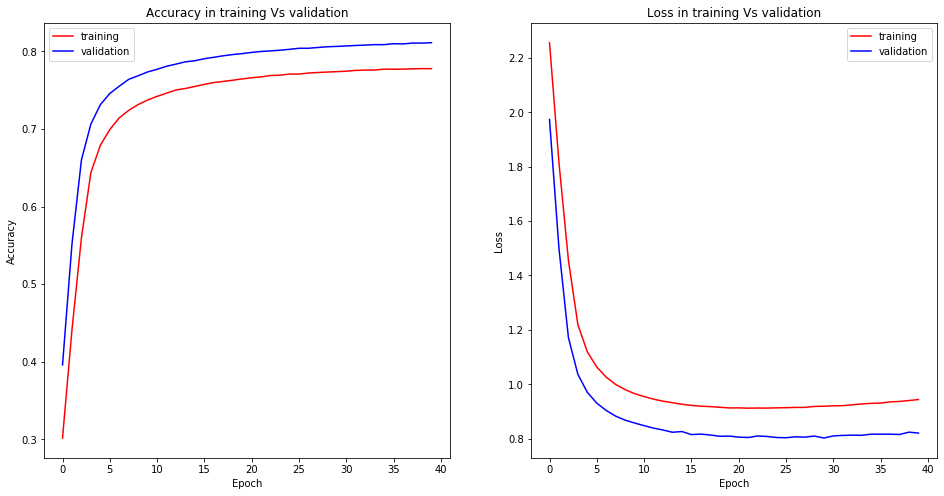

In [30]:
plot_history(history, 
             acc='accuracy', 
             val_acc='val_accuracy', 
             loss='loss', 
             val_loss='val_loss')

The resulting model looks good, it has $0.811$ or $81\%$ of accuracy in the validation set which is better than the manually constructed. And it requires significantly less parameters than the original one. So we will keep this model.

In [80]:
y_train.shape

(1087534, 10)

### Persist the model for further usage

In [34]:
base_path = "../../../models/keras/products"
definition_path = f"{base_path}/ann_products_definition.yaml"
weights_path = f"{base_path}/ann_products_definition.h5"
category_encoder_path = f"../../../models/sklearn/categories_encoder.sav"

In [32]:
ann_model_definition = ann_model.to_yaml()
with open(definition_path, 'w') as file:
    file.write(ann_model_definition)

ann_mode_weights = ann_model.save_weights(weights_path)

In [33]:
from keras.models import model_from_yaml
with open(definition_path, 'r') as file:
    product_class_predictor = model_from_yaml(file.read())

product_class_predictor.load_weights(weights_path)

In [35]:
import pickle
with open(category_encoder_path, 'wb') as model_file:
    pickle.dump(categories_encoder, model_file)

In [36]:
cats = categories_encoder.classes_.tolist()

### Validate against the test set

In [37]:
X_test_rs = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = np.where(product_class_predictor.predict(X_test_rs) > 0.5, 1., 0.)

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)


print(f"Accuracy:\n{acc}\n")
print(f"Classification Report:\n{cr}")

Accuracy:
0.7429422896203705

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    137672
           1       0.87      0.80      0.83     48530
           2       0.85      0.63      0.72     37623
           3       0.80      0.60      0.69     74889
           4       0.87      0.71      0.78     24037
           5       0.92      0.86      0.89     24689
           6       0.82      0.44      0.57      8429
           7       0.68      0.25      0.37     31483
           8       0.87      0.84      0.85     80553
           9       0.87      0.73      0.79     35317

   micro avg       0.88      0.75      0.81    503222
   macro avg       0.85      0.68      0.74    503222
weighted avg       0.87      0.75      0.80    503222
 samples avg       0.81      0.78      0.79    503222



Indeed it looks pretty good!. almost all the categories are predicted with an f1-score above the 50% except for category #7 (Sports & Outdoors).

Let's take a look at some individual instances.

### Looking at individual instances

In [55]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

def featurize_text(text: str):
    return d2v_model.infer_vector([word.lower() for word in tokenizer.tokenize(text)])

In [58]:
i = 0
featurized_document = featurize_text(reviews.iloc[i]['document']).reshape(1, -1, 1)
categories = reviews.iloc[i]['categories']
prediction = product_class_predictor.predict(featurized_document)

In [59]:
prediction.T

array([[8.4469275e-04],
       [2.8135465e-03],
       [1.0223718e-01],
       [2.4201906e-01],
       [7.7650611e-06],
       [2.1948947e-06],
       [2.7645112e-03],
       [6.3492106e-03],
       [6.4163697e-01],
       [1.3248643e-03]], dtype=float32)

In [65]:
pred = prediction.T.tolist()
pred_w_categories = list(zip(cats, pred))

In [68]:
final_predictions = list(filter(lambda x: x[1][0] > 0.1, pred_w_categories))
print(f"Actual categories: {categories}\n")
final_predictions

Actual categories: Home & Kitchen;Technology, Electronics & Accessories



[('Health & Personal Care', [0.10223717987537384]),
 ('Home & Kitchen', [0.24201905727386475]),
 ('Technology, Electronics & Accessories', [0.6416369676589966])]

In [70]:
print(f"Text: {reviews.iloc[0]['document']}")

Text: Jim from Ocala, Fl.
great replacement product. Has been in use for several months with no problem. This is a very good replacement battery. would order again inthe future.


Not bat at all! Let's try one at random.

In [73]:
import random

samples = [random.randint(0, reviews.shape[0]) for _ in range(5)]

for i in samples:
    featurized_document = featurize_text(reviews.iloc[i]['document']).reshape(1, -1, 1)
    categories = reviews.iloc[i]['categories']
    prediction = product_class_predictor.predict(featurized_document)
    pred = prediction.T.tolist()
    pred_w_categories = list(zip(cats, pred))
    final_predictions = list(filter(lambda x: x[1][0] > 0.1, pred_w_categories))
    print("#" * 20)
    print(f"Actual categories: \n {categories}\n")
    print(f"Predicted categories: \n {final_predictions}\n")
    print(f"Text: \n{reviews.iloc[i]['document']}")
    print("#" * 20)

####################
Actual categories: 
 Home & Kitchen

Predicted categories: 
 [('Home & Kitchen', [0.8230400681495667])]

Text: 
OEM carburetor
This product was the exact fit for the engine that is on my tractor. so far the part performance is flawless no leaks and problems.
####################
####################
Actual categories: 
 Books

Predicted categories: 
 [('Books', [0.9937159419059753])]

Text: 
Great information all in one place!
I would recommend this book to anyone already in network marketing and considering network marketing. Having 75 of the top in the industry share their experiences is priceless. Two things I love: is you see the reality of the success that can be had with consistency; and secondly that everyone started out with a vision and a dream and through consistency and perseverancegot to where they are today. Its an easy read and not one that you have to read from front to back in sequence. I have dogeared almost every page for a quick reference back. M

Definitely not bad!. Few misses so we'll keep this model.

In [47]:
categories_encoder.classes_.tolist()

['Books',
 'Clothing, Shoes & Jewelry',
 'Health & Personal Care',
 'Health, Fitness & Dieting',
 'Home & Kitchen',
 'Movies & TV',
 'Music',
 'Office & School Supplies',
 'Technology, Electronics & Accessories',
 'Toys & Games']

## Using the models to predict new entries
And here let's fabricate a review and submit it to the classifier and see that happens.

We took a real review from Amazon from [here](https://www.amazon.com/Support-Breathable-Neoprene-Sleeve-Adjustable/dp/B01LXAGV0H/ref=sr_1_24?dchild=1&fst=as%3Aoff&pf_rd_i=16225014011&pf_rd_m=ATVPDKIKX0DER&pf_rd_p=a3460e00-9eac-4cab-9814-093998a3f6d8&pf_rd_r=VKWG5JEAZB9TECRKBH10&pf_rd_s=merchandised-search-4&pf_rd_t=101&qid=1591042478&s=sporting-goods&sr=1-24) which is about a Workout related item, which says:

"This ankle support brace rocks! I have been recovering from a fractured ankle and have been beside myself as to what kind of brace or bandage I can wear to give me support and also act as a compression. This also needed to fit under my tennis shoe so I could wear it wherever I went. I couldn’t fit compression socks over my foot, and they were so very tight anyway. And all other ankle braces wouldn’t fit under the shoe. So for weeks and weeks I wore ace bandages which didn’t really do the job either. VOILA! This fantastic ankle brace does it all! It gives me really good, controlable compression and also supports my ankle AND goes under my tennis shoe comfortably! Yay!!!"

In [75]:
new_entry = "This ankle support brace rocks! I have been recovering from a fractured ankle and have been beside myself as to what kind of brace or bandage I can wear to give me support and also act as a compression. This also needed to fit under my tennis shoe so I could wear it wherever I went. I couldn’t fit compression socks over my foot, and they were so very tight anyway. And all other ankle braces wouldn’t fit under the shoe. So for weeks and weeks I wore ace bandages which didn’t really do the job either. VOILA! This fantastic ankle brace does it all! It gives me really good, controlable compression and also supports my ankle AND goes under my tennis shoe comfortably! Yay!!!"

In [78]:
from nltk import word_tokenize
features = featurize_text(new_entry).reshape(1, -1, 1)
prediction = product_class_predictor.predict(features)
pred = prediction.T.tolist()
pred_w_categories = list(zip(cats, pred))
final_predictions = list(filter(lambda x: x[1][0] > 0.1, pred_w_categories))
print("#" * 20)
print(f"Predicted categories: \n {final_predictions}\n")
print(f"Text: \n{new_entry}")
print("#" * 20)

####################
Predicted categories: 
 [('Clothing, Shoes & Jewelry', [0.8032526969909668]), ('Sports & Outdoors', [0.19674719870090485])]

Text: 
This ankle support brace rocks! I have been recovering from a fractured ankle and have been beside myself as to what kind of brace or bandage I can wear to give me support and also act as a compression. This also needed to fit under my tennis shoe so I could wear it wherever I went. I couldn’t fit compression socks over my foot, and they were so very tight anyway. And all other ankle braces wouldn’t fit under the shoe. So for weeks and weeks I wore ace bandages which didn’t really do the job either. VOILA! This fantastic ankle brace does it all! It gives me really good, controlable compression and also supports my ankle AND goes under my tennis shoe comfortably! Yay!!!
####################


Not bad at all, despite Sports & Outdoors had a small score compared with Clothing, it is true that the item selected is indeed some sort of object to wear, so it would be interesting to observe the multilabel result to derive the actual category.

In [79]:
from operator import itemgetter
final_predictions.sort(key=itemgetter(1), reverse=True)
final_predictions

[('Clothing, Shoes & Jewelry', [0.8032526969909668]),
 ('Sports & Outdoors', [0.19674719870090485])]

It was predicted as `Clothing` with $80\%$ of probability, and `Sports & Outdoors` with $19\%$ of probability. It is not bad.